In [62]:
import torch 

x = torch.Tensor([[0.0512, 0.0819, 0.5242, 0.8290, 0.6909],
         [0.0664, 0.0803, 0.4328, 0.1801, 0.1115],
         [0.0477, 0.0498, 0.5256, 0.7370, 0.9995],
         [0.0423, 0.0461, 0.5412, 0.4574, 1.0000],
         [0.0332, 0.0345, 0.6013, 0.2524, 0.7095],
         [0.0124, 0.0228, 0.4840, 0.3787, 0.0775],
         [0.0137, 0.0150, 0.6543, 0.5511, 0.0064]])
edge_index = torch.Tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5],
         [1, 2, 3, 4, 5, 6, 2, 3, 4, 5, 6, 3, 4, 5, 6, 4, 5, 6, 5, 6, 6]]).long()
edge_attr = torch.Tensor([[0.2260],[0.0546],[0.2210],
         [0.2618],[0.2698],[0.2068],
         [0.2775],[0.1947],[0.1674],
         [0.1277],[0.3061],[0.1665],
         [0.2965],[0.2162],[0.1656],
         [0.1346],[0.0720],[0.1220],
         [0.1352],[0.1843],[0.1928]])

In [51]:
linear = torch.nn.Linear(5,2)

linear(x)

tensor([[-0.4092, -0.0960],
        [-0.2857,  0.3190],
        [-0.2989, -0.2101],
        [-0.2095, -0.1197],
        [-0.2423,  0.0918],
        [-0.4049,  0.2873],
        [-0.5584,  0.3292]], grad_fn=<AddmmBackward>)

In [52]:
linear.state_dict()

OrderedDict([('weight',
              tensor([[ 0.3498, -0.0110, -0.4418, -0.3503,  0.2580],
                      [-0.1232,  0.2168,  0.3799, -0.3032, -0.4404]])),
             ('bias', tensor([-0.0825,  0.2490]))])

In [17]:
from torch_geometric.nn import MessagePassing

class GCNConv(MessagePassing):
    def __init__(self,n_in_node,n_in_edge,n_out):
        super(GCNConv,self).__init__(aggr='add')
        self.linear = torch.nn.Linear(2*n_in_node+n_in_edge,n_out);
    def forward(self, x, edge_index, edge_attr):
        self.messages = []
        return self.propagate(edge_index,x=x,edge_attr=edge_attr)
    
    def message(self,x_i, x_j, edge_attr):
        out = torch.cat([x_i,x_j-x_i,edge_attr],dim=1)
        out = self.linear(out)
        self.messages.append((x_i,x_j,edge_attr,out))
        return out
    
    def update(self,aggr_out):
        return aggr_out

In [18]:
x.shape,edge_index.shape,edge_attr.shape

(torch.Size([7, 5]), torch.Size([2, 21]), torch.Size([21, 1]))

In [28]:
layer = GCNConv(5,1,2)
true_out = layer(x,edge_index,edge_attr)

true_out

tensor([[ 0.0000,  0.0000],
        [-0.1290, -0.4445],
        [ 0.4433, -0.3137],
        [ 0.4822, -0.7074],
        [ 0.0793, -1.1414],
        [-0.5888, -1.8665],
        [-0.9600, -1.6114]], grad_fn=<ScatterAddBackward>)

In [71]:
def debug_compare(true,test):
    return ((true-test)**2).sum()

In [72]:
def linear(input,weights,biases):
    return torch.Tensor([ [(array*weight).sum()+bias for weight,bias in zip(weights,biases) ] for array in input ])

In [73]:
def message(x,edge_index,edge_attr):
    src,dest = edge_index
    msg = torch.cat([x[dest],x[src]-x[dest],edge_attr],dim=1)
    return linear(msg,layer.linear.weight,layer.linear.bias)

In [74]:
layer(x,edge_index,edge_attr)

tensor([[ 0.0000,  0.0000],
        [-0.1290, -0.4445],
        [ 0.4433, -0.3137],
        [ 0.4822, -0.7074],
        [ 0.0793, -1.1414],
        [-0.5888, -1.8665],
        [-0.9600, -1.6114]], grad_fn=<ScatterAddBackward>)

In [76]:
true_msg = layer.messages[0][-1]
new_msg = message(x,edge_index,edge_attr)
debug_compare(true_msg,new_msg)

tensor(9.5349e-15, grad_fn=<SumBackward0>)

In [40]:
def scatter_add(x,edge_index,msg):
    n_nodes,n_features = x.shape[0],msg.shape[1]
    out = torch.zeros((n_nodes,n_features))
    _,col = edge_index
    for e,u in enumerate(col):
        out[u] += msg[e]
    return out

In [41]:
def scatter_max(x,edge_index,msg):
    n_nodes,n_features = x.shape[0],msg.shape[1]
    out = torch.zeros((n_nodes,n_features))
    _,col = edge_index
    for e,u in enumerate(col):
        for i in range(n_features):
            out[u,i] = max(out[u,i],msg[e,i])
    return out

In [42]:
new_msg.shape

torch.Size([21, 2])

In [43]:
new_out = scatter_add(x,edge_index,new_msg)
# new_out = scatter_max(new_x,edge_index,new_msg)
debug_compare(true_out,new_out)

tensor(1.1380e-14, grad_fn=<SumBackward0>)

In [44]:
def full_layer(x,edge_index,edge_attr):
    msg = message(x,edge_index,edge_attr)
    out = scatter_add(x,edge_index,msg)
    return out

In [45]:
import sys,git
sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

def to_input(graph):
    return graph.x,graph.edge_index,graph.edge_attr

dataset = gnn.Dataset('data/signal-training',transform=gnn.to_uptri_graph)
len(dataset)

100000

In [46]:
from torch_geometric.loader import DataLoader

training,validation = gnn.train_test_split(dataset,0.2)

trainloader = DataLoader(training[:1000],batch_size=10,shuffle=True,num_workers=4)

In [47]:
def compare_models(graph):
    x,edge_index,edge_attr = to_input(graph)
    true_out = layer(x,edge_index,edge_attr)
    new_out = full_layer(x,edge_index,edge_attr)

    with torch.no_grad():
        return float(debug_compare(true_out,new_out))


In [48]:
comparison = [ compare_models(train) for train in trainloader ]

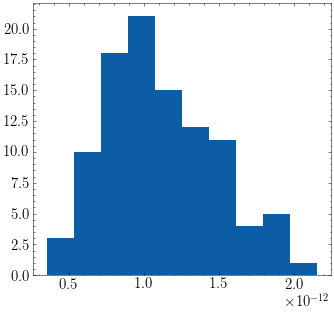

In [49]:
import matplotlib.pyplot as plt
import numpy 

plt.hist(comparison)
plt.show()

In [50]:
layer.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.1274,  0.2725, -0.2208,  0.0745,  0.2331, -0.0438,  0.0009,  0.0686,
                       -0.0600, -0.0723, -0.0197],
                      [-0.2133, -0.0064,  0.1091,  0.0283, -0.1003, -0.2419,  0.0016, -0.2718,
                       -0.0960, -0.1954, -0.0102]])),
             ('linear.bias', tensor([-0.0080, -0.2720]))])

In [56]:
src,dest = edge_index

In [57]:
src

tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5])